In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import albumentations as A
import cv2
import interpretability_toolkit.attributions as attr
import matplotlib.pyplot as plt
import timm
import torch
from albumentations.pytorch import ToTensorV2
from interpretability_toolkit.utils.plots import plot_images_heatmaps
from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_INCEPTION_STD,
)

Attribution = attr.Attribution
from huggingface_hub import hf_hub_download

In [29]:
path = f'ClementP/FundusDRGrading-vit_base_patch14_reg4_dinov2.lvd142m'
model = timm.create_model(f'hf_hub:{path}', pretrained=True, img_size=512, num_classes=1)


In [30]:
img = cv2.imread("fundus.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
                       A.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_INCEPTION_STD), ToTensorV2()])
img = transform(image=img)["image"].unsqueeze(0)


Generating heatmap with method:  attention_rollout
tensor([[3.2502]], device='cuda:0')


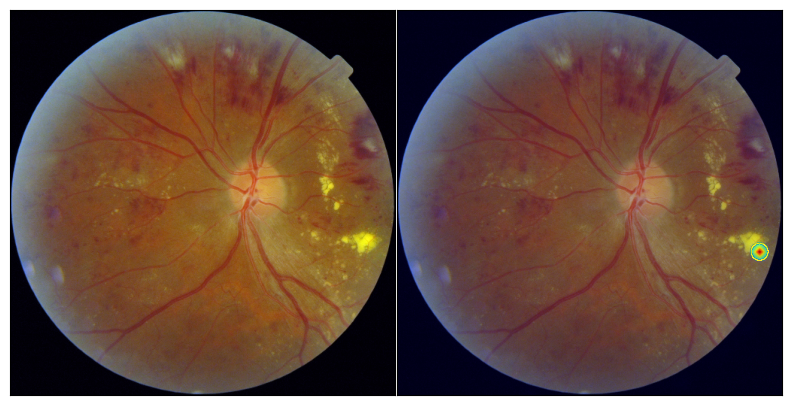

Generating heatmap with method:  chefer
tensor([[3.2502]], device='cuda:0')


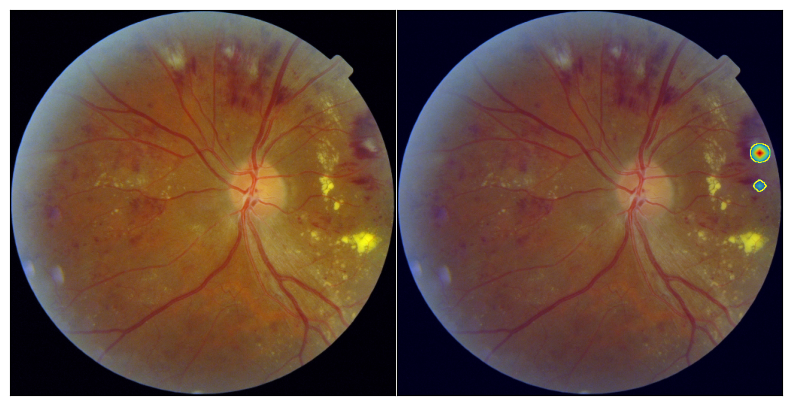

Generating heatmap with method:  focused_attention
tensor([[3.2502]], device='cuda:0')


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


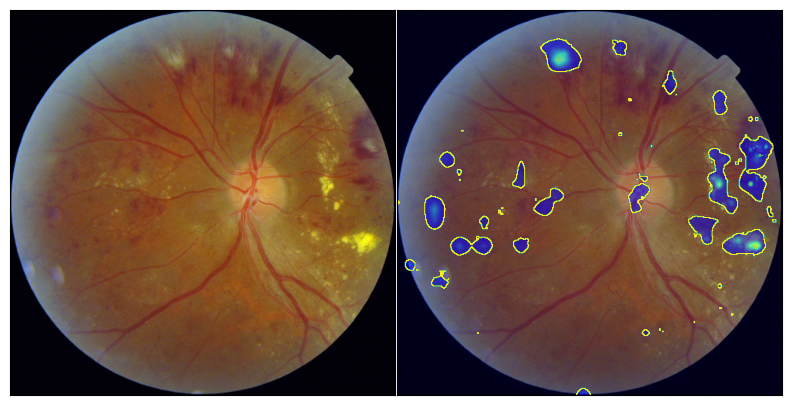

In [42]:
model = model.cuda(0)
attr = Attribution(model, sampling_points=1024, with_replacement=True, temperature=1.5, dilate_tokens=False, 
                   attribution_method='chefer', noise_level=0.) 

img = img.cuda(0)

methods = ["attention_rollout", "chefer", "focused_attention"]
for m in methods:
    print("Generating heatmap with method: ", m)
    with torch.no_grad():
        pred = model(img)
    print(pred)
    pred = torch.round(pred)
    attributions = attr.attribute(img, method=m, output=pred, discard_ratio=0.5, start_from=0,
                                    as_regression=True, 
                                head_fusion="mean")
    attributions = torch.nan_to_num(attributions, nan=0.0)
    fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold='otsu', use_sigmoid=True)
    plt.show()
